# Sentiment Analysis sobre reviews
						
El objetivo es construir un clasificador el cual pueda predecir si una revisión realizada por un usuario es positiva o negativa (buena o mala).
Para ello, se utiliza un conjunto de datos que pertenece a la plataforma Yelp. Esta, posee una red de usuarios, los cuales realizan opiniones sobre lugares nocturnos, espacios culturales, locales comerciales, entre otros.
- Realizar un análisis de features, así como su preparación necesaria antes de iniciar el desarrollo del modelo.
						
## Objetivos
Generar un modelo de machine learning el cual pueda clasificar review en inglés para la plataforma Yelp. El modelo recibirá una review de un usuario, y deberá ser capaz de determinar si esta es positiva o negativa.

## Dataset

Las features que contiene el  dataset son:
				
-  business_id: identificador del negocio al que se está realizando la review.
-  cool: cantidad de votos por haber sido una review “cool”.
-  date: fecha de realización de la revisión
-  funny: cantidad de votos para una revisión “divertida”.
-  review_id: identificador único de revisión (ofuscado).
-  stars: cantidad de estrellas otorgadas por el usuario en referencia a la review.
-  text: revisión realizada por el usuario sobre un determinado negocio.
-  useful: cantidad de votos recibido por los usuarios a los cuales le resultó útil la revisión.
-  user_id: id del usuario en la plataforma (ofuscado)
 
## Consideraciones

- No contamos con una variable target como pasa en problemas de la vida real. Por ello, un desafío extra que se presenta es cómo definir un target, basado en las features del dataset.
			
- Muchas veces cuando importamos un dataset pandas infiere que valor podría ser, de no encontrar un valor conocido pone uno por defecto. Validar que los tipos de datos de las features después de importarse correspondan con su valor intrínseco es una buena práctica.

-  Haga una rápida exploración de valores atípicos (outliers) del conjunto de datos. Realice los gráficos que considere pertinente para entender la naturaleza del problema.

## Evaluación
 								
Para la evaluación de los modelos utilizar las siguientes métricas:
 							
- Precision
- Recall
    - F1-score
    - Análisis de AUC ROC


In [1]:
# Imports utilizados a lo largo del práctico
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import numpy as np

import fasttext
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from yellowbrick.features import FeatureImportances
from yellowbrick.classifier import ConfusionMatrix, ClassificationReport, ROCAUC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_curve, roc_auc_score

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Carga dataset
data = pd.read_csv('reviews_yelp_nn.csv.gz', compression='gzip', sep="\t", error_bad_lines=False, quotechar = '"', low_memory=False)

In [3]:
# Shape, Columns,  Datatype
print(f"Shape of the dataset: {data.shape} \n")
print(f"Column names:\n {data.columns} \n")
print(f"Datatype of each column:\n {data.dtypes}")

Shape of the dataset: (3342958, 9) 

Column names:
 Index(['business_id', 'cool', 'date', 'funny', 'review_id', 'stars', 'text',
       'useful', 'user_id'],
      dtype='object') 

Datatype of each column:
 business_id     object
cool            object
date            object
funny          float64
review_id       object
stars          float64
text            object
useful         float64
user_id         object
dtype: object


Creo una columna nueva para la longitud de la review.

In [4]:
data['review_len']=data.text.astype(str).apply(len)

In [5]:
data.head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id,review_len
0,EhGPj8iJDIdaHnWg9d5BgA,0,2016-04-20 14:30:53,0.0,uJRdHLz4XNmDK5pOkWbZNA,5.0,"Best Dim Sum in the city, their cart service i...",0.0,POETn3fQcZ8ngLAARCATSg,281
1,VPcFNI-6HICR5SJM--KjNA,5,2013-05-14 03:08:12,2.0,TlPh8jy8bt_TSGfjEw-pvA,5.0,How... HOW did I not head down here sooner? Fo...,7.0,oUK6Xs5dPPnP4whFeZExGg,1546
2,ugdUuApH3pYXggW5qpbALg,0,2016-08-26 16:51:37,0.0,GmoBAVE1pTo0kjmeKrXmLQ,4.0,Carnitas were wonderful. First time there and ...,0.0,SiaSUNlKQK7f57WBPmyyNw,206
3,3fCxmmg8nHGaE5upJWQUrw,0,2016-03-24 17:23:19,0.0,ZHuM9P81zfuNuFZ5ThXNRg,5.0,Great staff who are always willing to help. I ...,0.0,PsH5Qi8R69WAlhNv8mXWRA,275
4,LAqbIi2TDn8BDvPB0nLVhQ,1,2012-10-25 15:02:48,0.0,-2Ce00mfWYP20yt7k6kARg,3.0,"This place is bigger, brighter, new so it's cl...",3.0,r-zUIQPaHzvIyL93wQaoiQ,289


veo como se distribuyen las longitudes de las reviews

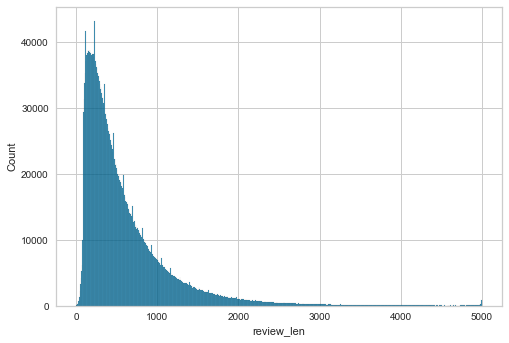

count   3342958.00000
mean        602.49914
std         568.62338
min           1.00000
25%         237.00000
50%         425.00000
75%         765.00000
max        5000.00000
Name: review_len, dtype: float64

In [6]:
sns.histplot(data=data, x='review_len')
plt.show()
pd.set_option('display.float_format', lambda x: '%.5f' % x)
data.review_len.describe()

In [7]:
data.shape

(3342958, 10)

Se eliminan aquellos registros cuyo texto es NaN

In [8]:
data.dropna(subset=['text'], inplace=True)

Se eliminan aquellos reviews con un sólo caracter

In [9]:
df = data[data.review_len > 2].copy()
df.shape

(3342905, 10)

Evalúo si hay correlación entre _stars_ y la longitud de las reviews

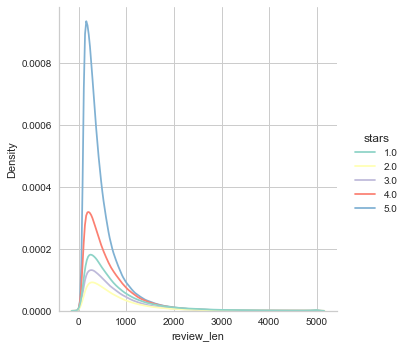

In [10]:
sns.displot(data=df,
            x='review_len',
            hue='stars',
            kind='kde',
            palette='Set3')

Hay 3 columnas para el voto. _funny_, _cool_ y _useful_. <br> 
Veo valores medios de esas categorias de voto repecto del la cantidad de _stars_ que le dieron en la review.

In [11]:
# Por alguna eventualidad, necesito que cool sea floatante.
df["cool"] = df.cool.astype(float)

In [12]:
df["text"] = df.text.astype(str)

Tomo los valores medios de los votos (estrellas) en las reviews y veo la correlación

<AxesSubplot:>

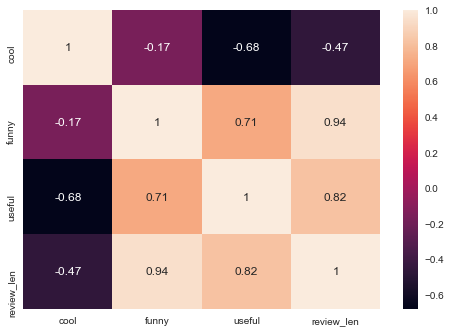

In [13]:
stval = df.groupby('stars').mean()
sns.heatmap(stval.corr(), annot=True)

Hay correlación negativa entre
* Cool y Useful
* Cool y Funny
* Cool y Length  <br>

Puedo decir que las reseñas marcadas como cool suelen ser breves y poco útiles para otros. <br>
Considerando que hay correlación positiva entre:

* Funny y Useful    
* Funny y Length
* Useful y Length <br>

Puedo decir que las reseñas más largas suelen ser divertidas y útiles.

Veo estadística asociada a la loinguitd de la review.

In [14]:
review_len_stats = df.review_len.describe(percentiles=[0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
review_len_stats

count   3342905.00000
mean        602.50866
std         568.62285
min           3.00000
5%          114.00000
10%         145.00000
20%         206.00000
30%         269.00000
40%         340.00000
50%         425.00000
60%         531.00000
70%         672.00000
80%         880.00000
90%        1261.00000
max        5000.00000
Name: review_len, dtype: float64

In [15]:
df = df[(df.review_len > review_len_stats.to_dict()['10%']) & (df.review_len < review_len_stats.to_dict()['70%']) ]

In [16]:

punct_list = list(string.punctuation)

In [17]:
def remove_punctuation(text):
    # lower case
    text = text.lower()
    # replace striplines
    text = text.replace('\n', '')
    # remove punctuation
    for punc in punct_list:
        if punc in text:
            text = text.replace(punc, '')
    return text.strip()

In [18]:
print(df["text"].iloc[0])

Best Dim Sum in the city, their cart service is great and offer big selection of quality dim sum.  You can order off the menu too if there is something you haven't seen come around.  It is a little more expensive but you can't beat it, and the view is perfect for a weekend brunch.


In [19]:
df["text"] = df.text.apply(remove_punctuation)

In [20]:
print(df["text"].iloc[0])

best dim sum in the city their cart service is great and offer big selection of quality dim sum  you can order off the menu too if there is something you havent seen come around  it is a little more expensive but you cant beat it and the view is perfect for a weekend brunch


In [21]:
def get_review_language(row):
    try:
        language = fmodel.predict(row)[0][0].split("__label__")[1]
    except:
        language = "error"
        
    return language

In [22]:
path_to_pretrained_model = 'c:/Users/amancini/Downloads/lid.176.bin'
fmodel = fasttext.load_model(path_to_pretrained_model)
df["language"] = df.text.apply(get_review_language)
# lenguages detectados
df.language.unique()
df.language.value_counts(normalize=True)*100

en    99.53901
fr     0.37258
es     0.04330
de     0.01888
zh     0.00884
ja     0.00769
pt     0.00290
it     0.00230
sv     0.00130
tr     0.00075
nl     0.00075
da     0.00050
pl     0.00025
no     0.00020
tl     0.00015
vi     0.00010
fi     0.00010
mk     0.00005
cs     0.00005
la     0.00005
ceb    0.00005
ca     0.00005
ilo    0.00005
sl     0.00005
oc     0.00005
Name: language, dtype: float64

Me quedo con los reviews en inglés

In [23]:
data_to_process_english = df[df.language == 'en']
data_to_process_english.shape

(1993000, 11)

Me quedo con aquellos reviews que tienen _stars_ 1 y 5 para tener clasificación negativa positiva (podría tomar star=3 y tener una review promedio).

In [24]:
data_to_classify = data_to_process_english[(data_to_process_english['stars']==1) | (data_to_process_english['stars']==5)]
data_to_classify.shape

(1233337, 11)

In [25]:
data_to_classify_sampled = data_to_classify.sample(frac=0.05, random_state=1)
data_to_classify_sampled.shape

(61667, 11)

Veamos un gráfico bivariado de las variables resultantes

In [26]:
#x = data_to_classify_sampled.loc[:,['cool', 'useful', 'review_len', 'stars']]
#sns.pairplot(x,
#             kind="kde",
#             palette='rainbow')

# División del conjunto de datos
Tomo reviews y stars como variables para la clasificación.<br>

In [27]:
# Separo el datase
x = data_to_classify_sampled['text']
y = data_to_classify_sampled['stars']

## Vectorization
Ahora vectorizaremos una única revisión y vemos los resultados

In [28]:
# conversión de palabras a vector considerando los stop_words en inglés
vocab = CountVectorizer(stop_words='english').fit(x)

In [29]:
print(len(vocab.vocabulary_))

71360


Vectorización de todo el conjunto de revisión y comprobación de la matriz dispersa:

In [30]:
x = vocab.transform(x)
# Tamaño de la matriz
print("Shape of the sparse matrix: ", x.shape)
# Ocurrencias no nulas
print("Non-Zero occurences: ",x.nnz)
# Matriz de densidad
density = (x.nnz/(x.shape[0]*x.shape[1]))*100
print("Density of the matrix = ",density)

Shape of the sparse matrix:  (61667, 71360)
Non-Zero occurences:  1661926
Density of the matrix =  0.03776626355891956


Dividir el conjunto de datos X en conjunto de entrenamiento y prueba:

In [31]:
x_train,x_test,y_train,y_test = train_test_split(x, y,test_size=0.2,random_state=101)

# Desbalance de clases

5.00000   0.78230
1.00000   0.21770
Name: stars, dtype: float64


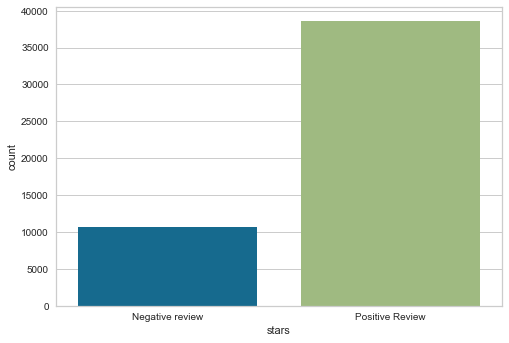

In [32]:
print(y_train.value_counts(normalize=True))
g = sns.countplot(x=y_train)
g.set_xticklabels(['Negative review','Positive Review'])
plt.show()

In [33]:
over_smote = SMOTE(sampling_strategy=1)
x_train_smote, y_train_smote = over_smote.fit_resample(x_train, y_train)

5.00000   0.50000
1.00000   0.50000
Name: stars, dtype: float64


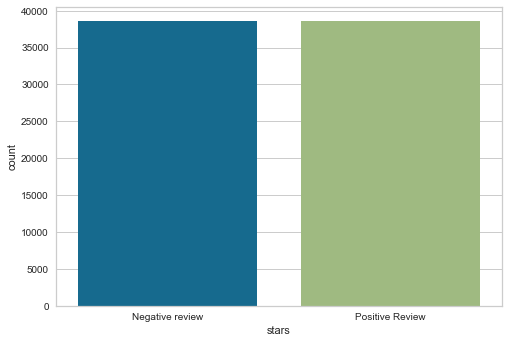

In [34]:
print(y_train_smote.value_counts(normalize=True))
g = sns.countplot(x=y_train_smote)
g.set_xticklabels(['Negative review','Positive Review'])
plt.show()

# Modelado:
Ahora varios algoritmos de ML para ver cuál ofrece el mejor rendimiento.
- Multinomial Naive Bayes
- Random Forest
- Decision Tree
- Support Vector Machine
- K Nearest Neighbour Algorithm
- XGBoost Classifier

In [35]:
mnb = MultinomialNB()
rmfr = RandomForestClassifier()
dt = DecisionTreeClassifier()
svm = SVC(random_state=101, probability=True)
knn = KNeighborsClassifier(n_neighbors=10)
xgb = XGBClassifier()

models = [mnb, rmfr, dt, svm, knn, xgb]
#models = [mnb, rmfr, dt, knn, xgb]

MultinomialNB
Classification Report:
              precision    recall  f1-score   support

         1.0       0.88      0.93      0.90      2714
         5.0       0.98      0.96      0.97      9620

    accuracy                           0.96     12334
   macro avg       0.93      0.95      0.94     12334
weighted avg       0.96      0.96      0.96     12334



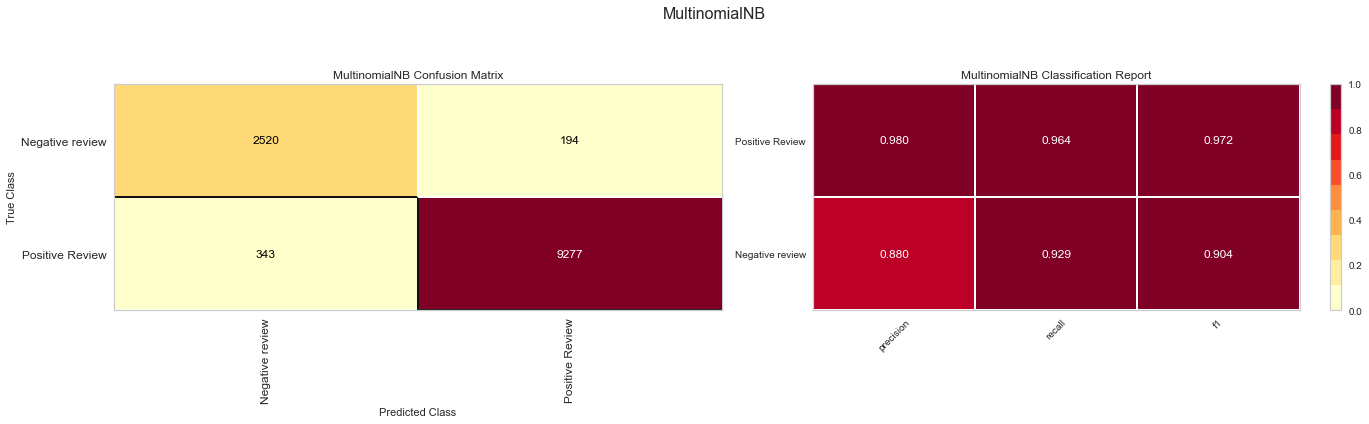

RandomForestClassifier
Classification Report:
              precision    recall  f1-score   support

         1.0       0.86      0.80      0.83      2714
         5.0       0.94      0.96      0.95      9620

    accuracy                           0.93     12334
   macro avg       0.90      0.88      0.89     12334
weighted avg       0.93      0.93      0.93     12334



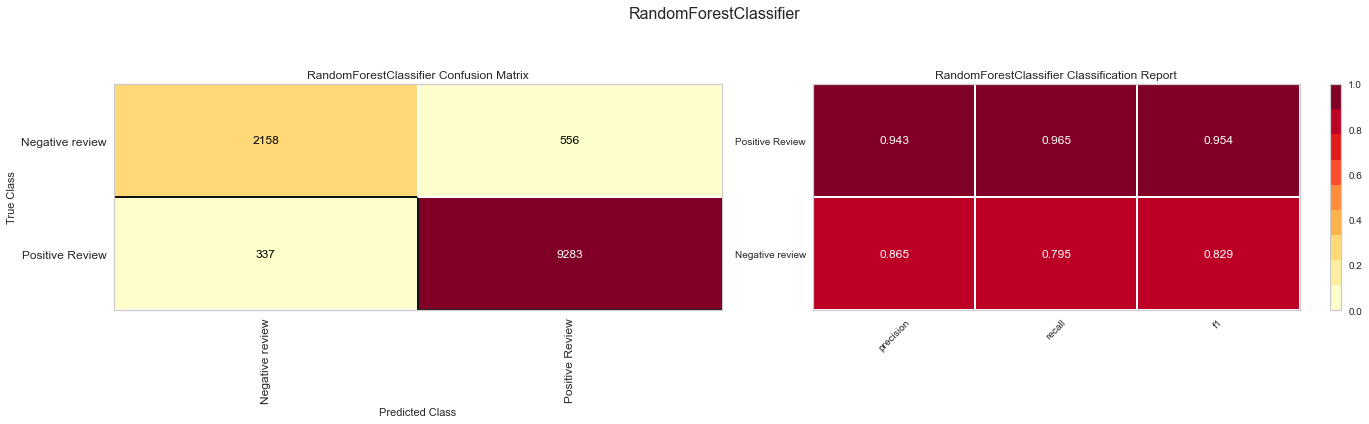

DecisionTreeClassifier
Classification Report:
              precision    recall  f1-score   support

         1.0       0.73      0.77      0.75      2714
         5.0       0.93      0.92      0.93      9620

    accuracy                           0.89     12334
   macro avg       0.83      0.84      0.84     12334
weighted avg       0.89      0.89      0.89     12334



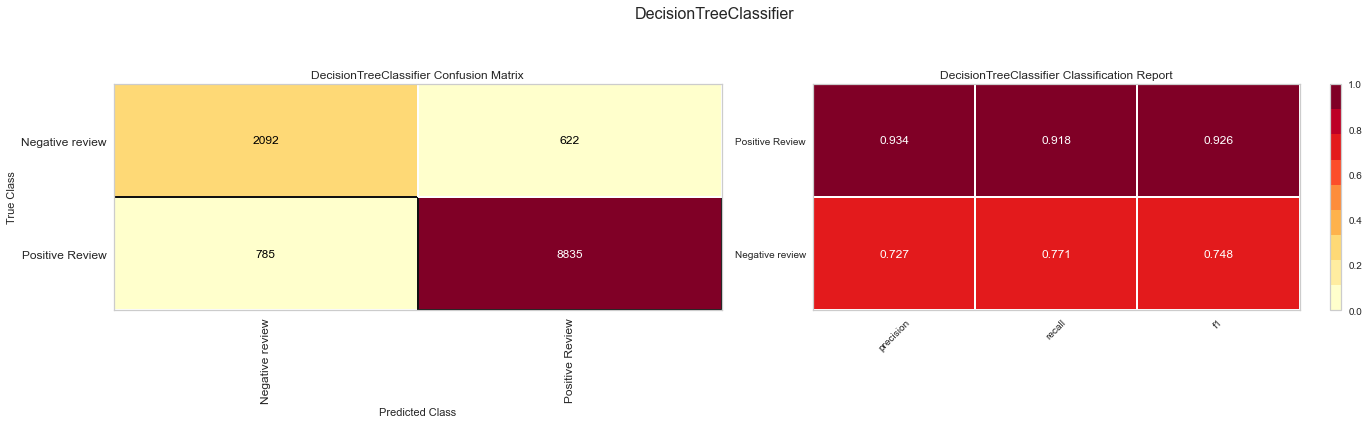

SVC
Classification Report:
              precision    recall  f1-score   support

         1.0       0.92      0.89      0.90      2714
         5.0       0.97      0.98      0.97      9620

    accuracy                           0.96     12334
   macro avg       0.94      0.93      0.94     12334
weighted avg       0.96      0.96      0.96     12334



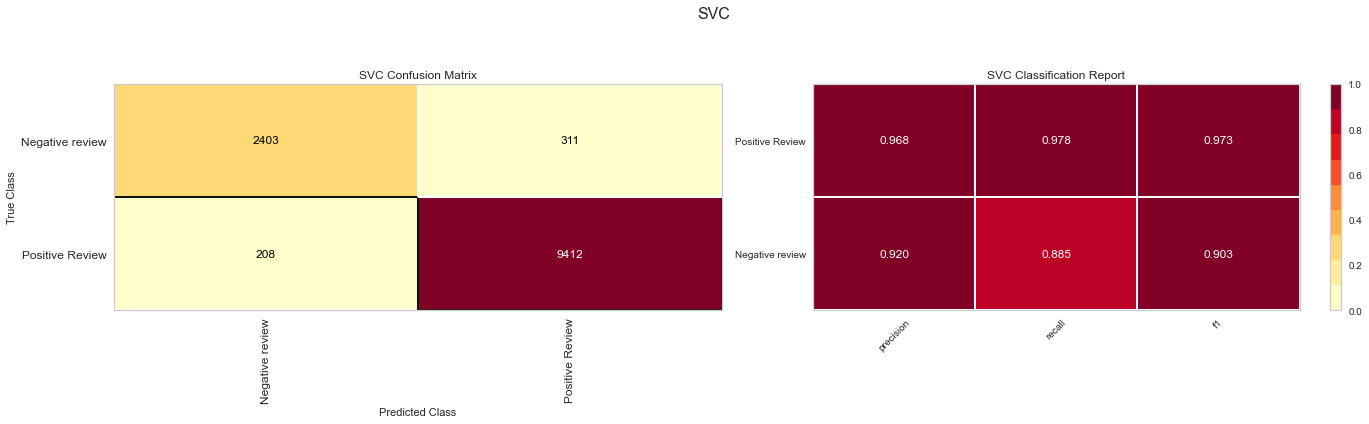

KNeighborsClassifier
Classification Report:
              precision    recall  f1-score   support

         1.0       0.22      1.00      0.36      2714
         5.0       1.00      0.01      0.01      9620

    accuracy                           0.23     12334
   macro avg       0.61      0.50      0.19     12334
weighted avg       0.83      0.23      0.09     12334



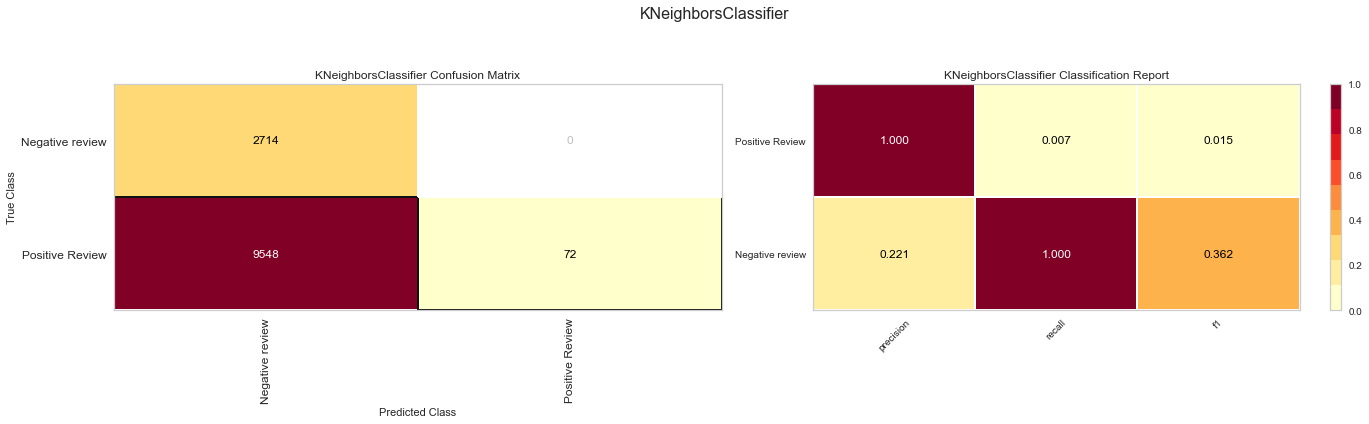

XGBClassifier


c:\program files\python\envs\base\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:19:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Classification Report:
              precision    recall  f1-score   support

         1.0       0.92      0.87      0.89      2714
         5.0       0.96      0.98      0.97      9620

    accuracy                           0.95     12334
   macro avg       0.94      0.92      0.93     12334
weighted avg       0.95      0.95      0.95     12334



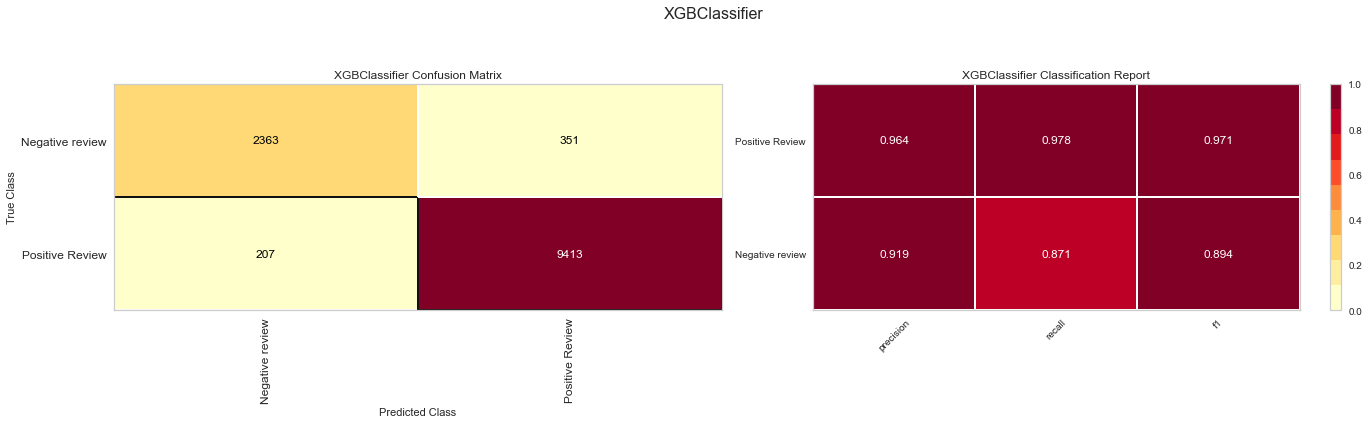

In [36]:
classes = ["Negative review","Positive Review"]

for model in models:
    print(type(model).__name__)
    # Pipeline        
    training_pipeline = make_pipeline(model)
    # Entrenamiento
    training_pipeline.fit(x_train_smote, y_train_smote)
    # Predicción
    y_pred = training_pipeline.predict(x_test)                        

    # Visualización con yellowbrick
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,6))

    # Visualizaciones a mostrar
    visualgrid =[
                ConfusionMatrix(model, ax=axes[0], classes=classes),
                ClassificationReport(model, ax=axes[1], classes=classes),
                ]
    
    pred = model.predict(x_test)

    print("Classification Report:")
    print(classification_report(y_test,pred))
    
    for viz in visualgrid:
        viz.fit(x_train_smote,y_train_smote)
        viz.score(x_test, y_test)
        viz.finalize()

    plt.suptitle(type(model).__name__ , fontsize=16)
    plt.subplots_adjust(top=0.8)
    plt.show()  
 

In [37]:
fpr_list = []
tpr_list = []

for model in models:
    print(model)
    model.fit(x_train_smote, y_train_smote)
    y_pred = model.predict_proba(x_test)

    y_pred_pos = y_pred[:,1]
    fpr, tpr, threshold = roc_curve(y_test, y_pred_pos, pos_label=5)
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    print('Area Under Curve (AUC) positive review: ', roc_auc_score(y_test, y_pred_pos))
    
    #y_pred_neg = y_pred[:,0]
    #fpr, tpr, threshold = roc_curve(y_test, y_pred_neg, pos_label=1)
    #fpr_list.append(fpr)
    #tpr_list.append(tpr) 
    #print('Area Under Curve (AUC) negative review: ', roc_auc_score(y_test, y_pred_neg))
    print()

MultinomialNB()
Area Under Curve (AUC) positive review:  0.9875205487217278

RandomForestClassifier()
Area Under Curve (AUC) positive review:  0.9717069189250471

DecisionTreeClassifier()
Area Under Curve (AUC) positive review:  0.8472490374848518

SVC(probability=True, random_state=101)
Area Under Curve (AUC) positive review:  0.9883802245077117

KNeighborsClassifier(n_neighbors=10)
Area Under Curve (AUC) positive review:  0.5396482319289984

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate

c:\program files\python\envs\base\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Area Under Curve (AUC) positive review:  0.9862002598369584



In [38]:
def plot_roc_curve(fpr, tpr, title_str):
    plt.figure(figsize=(12,7))    
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    for i in range(0, len(fpr)):
        plt.plot(fpr[i], tpr[i], label=str(models[i]))
        
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title_str)   
    plt.legend()   
    plt.grid(which='both')

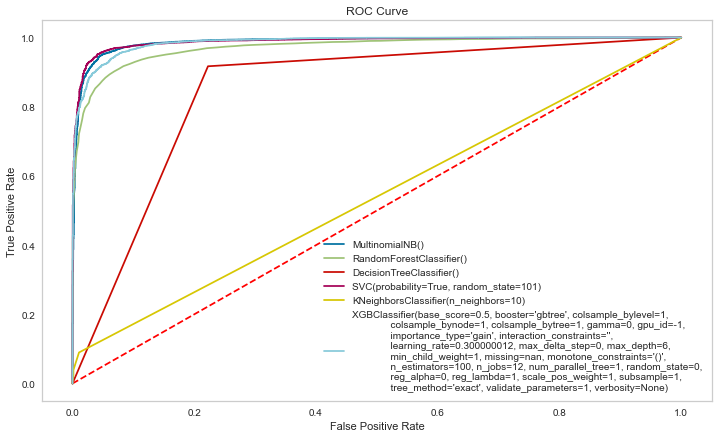

In [39]:
plot_roc_curve(fpr_list, tpr_list, title_str='ROC Curve')

# Predicción de reviews
Veamos la predicción de reviews

In [40]:
stars = [1, 2, 3, 4, 5]

for star in stars:
    idx = random.randint(0,data.shape[0])
    print(f"......................... \nStar: {star}")
    review = data[data['stars'] == star].text.iloc[10]
    print(f"{review}")
    pr_t = vocab.transform([review])
    print()
    for model in models:
        print("*****************")
        print(f"{type(model).__name__}")
        print(f"Actual rating: {data[data['stars'] == star].stars.iloc[0]} / Predicted Rating: {model.predict(pr_t)[0]}")    
        print()

......................... 
Star: 1
Used to always go there with friends for their beef ribs, they recently changed something about the beef ribs and now they taste horrible! cutting corners perhaps?

*****************
MultinomialNB
Actual rating: 1.0 / Predicted Rating: 1.0

*****************
RandomForestClassifier
Actual rating: 1.0 / Predicted Rating: 1.0

*****************
DecisionTreeClassifier
Actual rating: 1.0 / Predicted Rating: 1.0

*****************
SVC
Actual rating: 1.0 / Predicted Rating: 1.0

*****************
KNeighborsClassifier
Actual rating: 1.0 / Predicted Rating: 1.0

*****************
XGBClassifier
Actual rating: 1.0 / Predicted Rating: 1.0

......................... 
Star: 2
I've had breakfast here, which has always been good. Tonight was the first time I ate dinner here. I ordered shrimp & grits and was disgusted. Two bricks of grits absolutely drowned in basic white sausage gravy. Awful!

*****************
MultinomialNB
Actual rating: 2.0 / Predicted Rating: 1.0

## Predicción de stars
Tomo el modelo del XGBoost que fue el que mejor desempeño presenta y analizo la predicción de reviews con _stars_ 1,2,3,4,5

In [41]:
one_star_df = data[data.stars == 1]
two_star_df = data[data.stars == 2]
tree_star_df = data[data.stars == 3]
four_star_df = data[data.stars == 4]
five_star_df = data[data.stars == 5]

In [42]:
one_star_review = one_star_df['text'].astype(str)
two_star_review = two_star_df['text'].astype(str)
tree_star_review = tree_star_df['text'].astype(str)
four_star_review = four_star_df['text'].astype(str)
five_star_review = five_star_df['text'].astype(str)

In [43]:
max_row_size = np.min([one_star_df.shape[0],
                       two_star_df.shape[0],
                       tree_star_review.shape[0],
                       four_star_review.shape[0],
                       five_star_review.shape[0]])

In [44]:
one_star_review_predict = []
two_star_review_predict = []
tree_star_review_predict = []
four_star_review_predict = []
five_star_review_predict = []
# tomo 500 reviews al azar como para tener una referencia
N = 500
for k in range(N):  
    idx = random.randint(0,max_row_size)
    
    review = one_star_review.iloc[idx]
    nr_t = vocab.transform([review])
    one_star_review_predict.append(xgb.predict(nr_t)[0])
    
    review = two_star_review.iloc[idx]
    nr_t = vocab.transform([review])
    two_star_review_predict.append(xgb.predict(nr_t)[0])
    
    review = tree_star_review.iloc[idx]
    nr_t = vocab.transform([review])
    tree_star_review_predict.append(xgb.predict(nr_t)[0])
    
    review = four_star_review.iloc[idx]
    nr_t = vocab.transform([review])
    four_star_review_predict.append(xgb.predict(nr_t)[0])
    
    review = five_star_review.iloc[idx]
    nr_t = vocab.transform([review])
    five_star_review_predict.append(xgb.predict(nr_t)[0])        

In [45]:
pd.options.display.float_format = "{:,.2f}".format
class_map = pd.DataFrame([five_star_review_predict, 
                          four_star_review_predict, 
                          tree_star_review_predict, 
                          two_star_review_predict, 
                          one_star_review_predict]).T  
class_map.columns=['5 stars','4 stars','3 stars','2 stars','1 star']
resume = class_map.apply(lambda x: x.value_counts(normalize=True)*100)
resume.rename(index={1: 'negative review', 5: 'positive review'})

,5 stars,4 stars,3 stars,2 stars,1 star
negative review,2.00,6.40,29.00,60.20,86.40
positive review,98.00,93.60,71.00,39.80,13.60
